In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import numpy as np
import regex as reg

%matplotlib inline  

Extracting references from texts:

In [2]:
!python ./Scripts/reference_extraction.py 

	Number of pdf documents :  874
	Number of documents for which we have an extracted reference section:  874
	Percentage of unparsed references: 0.004
	Number of unparsed references:  59
	Number of properly parsed references:  14686
	Saved reference list to: data/ as References.csv
	Saved to individual authors list: data/ as Reference_authors.csv


Loading references as previously extracted:

In [3]:
references = pd.read_csv('data/References.csv', index_col=0)

In [4]:
references.head()

,ref,file,ref_parsed,year,identifier
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,"Lave, J., & Wenger, E. (1991)",1991.0,"Lave, J., & Wenger, E. (1991). Situated learni..."
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2013.0,"Miles, M. B., Huberman, A. M., & Saldana, J. (..."
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",1997.0,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish..."
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,"Rogoff, B. (1995)",1995.0,"Rogoff, B. (1995). Observing sociocultural act..."
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2012.0,"Shirk, J., Ballard, H., Wilderman, C., Phillip..."


Some sample references, and their corresponding identifier:

In [5]:
sample = references[['ref', 'identifier']].sample(4)
_ = [print("Ref: ",r, '\nIdentifier: ', s,) for r, s in zip(sample.ref.tolist(), sample.identifier.tolist())]

Ref:  Jones, B. L., & Bjelland, D. (2004). International experiential learning in agriculture. Proceedings of the 20th Annual Conference, Association for International Agricultural and Extension Education, 963–964. http://www.aiaee.org/2004/Carousels/jones-carousel-NEW.pdf 
Identifier:  Jones, B. L., & Bjelland, D. (2004). International experiential learning in agriculture
Ref:  Saxe, G. B. (1991). Culture and cognitive development: Studies in mathematical understanding. Hillsdale, NJ: Lawrence Erlbaum Associates. 
Identifier:  Saxe, G. B. (1991). Culture and cognitive development: Studies in mathematical understanding
Ref:  Kuhn, T. (1962). The Structure of Scientific Revolutions (3th ed.). Chicago, Il: University of Chicago Press. 
Identifier:  Kuhn, T. (1962). The Structure of Scientific Revolutions (3th ed
Ref:  Wise, A. F., et al. (2013). Learning analytics for online discussions: A pedagogical model for intervention with embedded and extracted analytics. In D. Suthers & K. Verber

### First we check the most cited citations:

Scardamalia, M. (2002). Collective cognitive responsibility for the advancement of knowledge                                   32
Lave, J., & Wenger, E. (1991). Situated learning: Legitimate peripheral participation                                          32
Jordan, B., & Henderson, A. (1995). Interaction analysis: Foundations and practice                                             31
Scardamalia, M., & Bereiter, C. (2006). Knowledge building: Theory, pedagogy, and technology                                   23
Papert, S. (1980). Mindstorms: Children, computers, and powerful ideas                                                         20
Barron, B. (2003). When smart groups fail                                                                                      19
Bereiter, C. (2002). Education and mind in the knowledge age                                                                   16
Vygotsky, L. S. (1978). Mind in society: The development of higher psychological processes

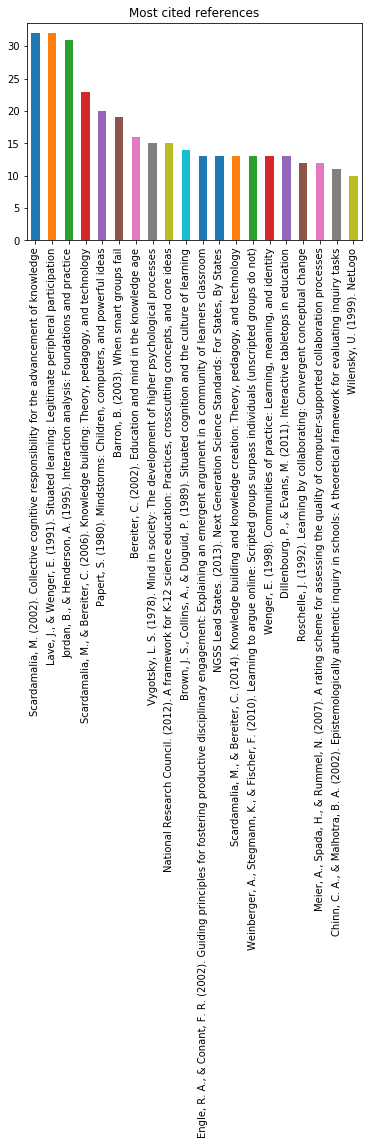

In [6]:
plt.title('Most cited references')
references.identifier.value_counts().head(20).plot(kind='bar')
references.identifier.value_counts().head(10)

### Looking at authors in dataset & the ones they reference

In [7]:
reference_authors = pd.read_csv('data/Reference_authors.csv', index_col=0)
reference_authors.shape

(45194, 6)

In [8]:
reference_authors.drop_duplicates(inplace=True)
reference_authors.shape

(34634, 6)

In [9]:
reference_authors.head()

,ref,file,ref_parsed,year,identifier,author
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,"Lave, J., & Wenger, E. (1991)",1991.0,"Lave, J., & Wenger, E. (1991). Situated learni...",Lave J.
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2013.0,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",Miles M. B.
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",1997.0,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",Pea R. D.
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,"Rogoff, B. (1995)",1995.0,"Rogoff, B. (1995). Observing sociocultural act...",Rogoff B.
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2012.0,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",Shirk J.


We check the most cited author:

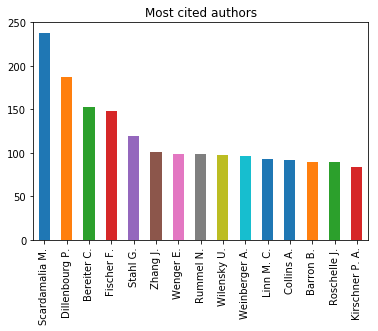

In [10]:
plt.title('Most cited authors')
reference_authors.author.value_counts().head(15).plot(kind='bar')

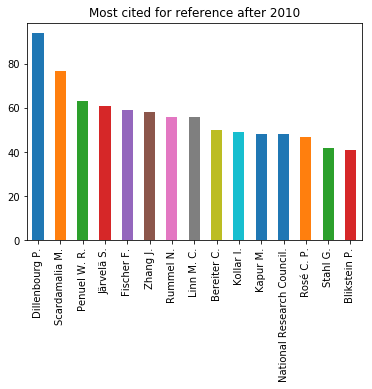

In [11]:
plt.title('Most cited for reference after 2010')
reference_authors[reference_authors.year > 2010].author.value_counts().head(15).plot(kind='bar')

We now merge on the shortened name as it can be found in the citation.

**Note** that we might get illegitemate merges, as the short name is not unique, even within the metadata dataset!

Load the metadata:

In [12]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0)

In [13]:
reference_edges = pd.merge(metadata, reference_authors, on='file')

reference_edges.sample(2)

,file,subject,iso,uri,type,publisher,title,issued,accessioned,citation,...,abstract,long_name,author_order,shortend_names,identifier_x,ref,ref_parsed,year,identifier_y,author
95281,import2018_38,"['Educational Data Mining', 'Action logs analy...",en,https://doi.dx.org/10.22318/cscl2018.312,Book chapter,International Society of the Learning Science...,Matching Data-Driven Models of Group Interacti...,2018-07,2018-11-04 23:14:21+00:00,"Paquette, L., Bosch, N., Mercier, E., Jung, J....",...,Despite an increasing emphasis on the use of c...,"Bosch, Nigel",1,Bosch N.,"Paquette, L., Bosch, N., Mercier, E., Jung, J....","Mierswa, I., Wurst, M., Klinkenberg, R., Schol...","Mierswa, I., Wurst, M., Klinkenberg, R., Schol...",2006.0,"Mierswa, I., Wurst, M., Klinkenberg, R., Schol...",Euler T.
26574,import2016short_158,NaN,en,https://doi.dx.org/10.22318/icls2016.158,Book chapter,Singapore: International Society of the Learni...,Exploring the Relationship Between Gesture and...,2016-07,2017-06-19 11:36:28+00:00,"Alameh, S., Morphew, J., Mathayas, N., & Lindg...",...,Leading middle school students to effectively ...,"Alameh, Sahar",0,Alameh S.,"Alameh, S., Morphew, J., Mathayas, N., & Lindg...","Alibali, M. W., & Nathan, M. J. (2012). Embodi...","Alibali, M. W., & Nathan, M. J. (2012)",2012.0,"Alibali, M. W., & Nathan, M. J. (2012). Embodi...",Nathan M. J.


#### We look at how the references are distributed over the years:

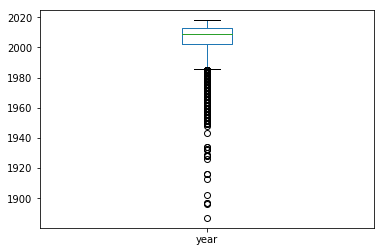

In [14]:
references.year.plot(kind='box')

In [15]:
reference_edges.rename(columns={'shortend_names': 'author', 'author': 'cited'}, inplace=True)

We don't see much but CSCL has less early (pree 1920) outiers

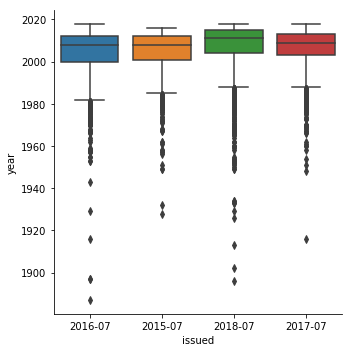

In [16]:
sns.catplot(data=reference_edges[['ref','issued', 'year']][~reference_edges.ref.duplicated()], x='issued', y='year', kind='box')

We have an interesting shift to newer sources in 2018:

In [17]:
reference_edges[['ref','issued', 'year']][~reference_edges.ref.duplicated()].groupby('issued').year.mean()

issued
2015-07    2004.944413
2016-07    2004.681293
2017-07    2006.698529
2018-07    2007.583138
Name: year, dtype: float64

In [18]:
reference_edges[['ref','issued', 'year']][~reference_edges.ref.duplicated()].groupby('issued').year.median()

issued
2015-07    2008.0
2016-07    2008.0
2017-07    2009.0
2018-07    2011.0
Name: year, dtype: float64

## Analyzing author reference relationship

### Self citations:

In [19]:
reference_edges[reference_edges.author == reference_edges.cited].author.value_counts().head()

Zhang J.           80
Rummel N.          61
Trausan-Matu S.    50
Sharma K.          35
Kollar I.          27
Name: author, dtype: int64

### Number of authors in and out of conference

In and out of conference citations, quick calculation:

In [20]:
print('Number of distinct authors ', len(reference_edges.author.unique()))
print('Number of distinct cited authors by some author in the conference ', len(reference_edges.cited.unique()))
print('Number of authors that where cited by an other author in the confernce :' , len(set(reference_edges.cited.tolist()).intersection(set(reference_edges.author.tolist()))))

Number of distinct authors  1444
Number of distinct cited authors by some author in the conference  13224
Number of authors that where cited by an other author in the confernce : 806


In [21]:
reference_edges = reference_edges[['cited', 'author', 'year', 'ref']][reference_edges.year.notna()]

Example of how one can match the string:

In [22]:
match_conference = ' JLS |Journal of the Learning Sciences|CSCL|ICLS|ijCSCL|Computer(-| |)Supported Collaborative Learning'
re.search(match_conference,'bjfejf ICLS')

<re.Match object; span=(7, 11), match='ICLS'>

Find references belong to conference:

In [23]:
mask_c_s = reference_edges.ref.map(lambda x: True if re.search(match_conference, x) else False)

In [24]:
in_conference = set(reference_edges[mask_c_s].cited.unique())

We limit the range of years to get people that are still "active"

In [25]:
not_in_conference = list(set(reference_edges[reference_edges.year > 2010].cited) - in_conference.union(set(reference_edges.author)))

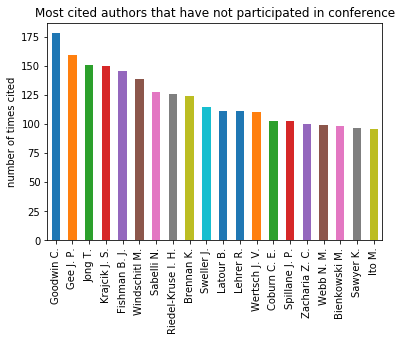

In [26]:
#todo: filter out organisations
# todo: deal with non overlapping names
plt.title('Most cited authors that have not participated in conference')
plt.ylabel('number of times cited')
# check that not in conference and is indeed author
is_human = reference_edges.dropna().cited.map(lambda x: True if reg.search(r'\p{Lu}\.',x) else False)
reference_edges[(reference_edges.cited.isin(not_in_conference)) & (is_human)].cited.value_counts().head(20).plot(kind = 'bar')

In [27]:
reference_edges[(reference_edges.cited.isin(not_in_conference)) & (reference_edges.cited == 'Goodwin C.')].ref.sample(4).tolist()

['Goodwin, C. (2003). The semiotic body in its environment. In J. Coupland & R. Gwyn (Eds.), Discourses of the body (pp. 19-42). New York: Palgrave/Macmillan.',
 'Koschmann, T., LeBaron, C., Goodwin, C., & Feltovich, P. (2011). “Can you see the cystic artery yet?” A simple matter of trust. Journal of Pragmatics, 43(2), 521–541.',
 'Goodwin, C. (2009). Video and the analysis of embodied human interaction. In U. T. Kissmann (Ed.), Video interaction analysis (pp. 21 – 40). Peter Lang GmbH. Frankfurt am Main.',
 'Streeck, J., Goodwin, C. & LeBaron, C. (2011). Embodied interaction in the material world: An introduction. In J. Streeck, C. Goodwin & C. Lebaron (Eds.), Embodied interaction. Language and body in the material world. Cambridge, MA: Cambridge University Press.']

In [28]:
reference_edges[(reference_edges.cited.isin(not_in_conference)) & (reference_edges.cited == 'Gee J. P.')].ref.sample(4).tolist()

['Gee, J. P. (2004). Situated language and learning: A critique of traditional schooling. New York: Routledge.',
 'Moss, P. A., Pullin, D. C., Gee, J. P., Haertel, E. H., & Young, L. J. (2008). Assessment, equity, and opportunity to learn. Cambridge, MA: Cambridge University Press.',
 'Gee, J. P. (2007b). Good Video Games and Good Learning: New Literacies and Digital Epistemologies. New York: Peter Lang Publishing.',
 'Gee, J. P. (2001). Identity as an Analytic Lens for Research in Education. Review of Educational Research, 25, 99–125.']

# extracting conference, journal from refrence string

Example of how we can split up the text, which is later used to extract the conference/journal if present:

In [29]:
text = references.sample().ref.item()
split_ref = r'(\.|\?) (?=[\p{Lu}][\p{L}])'
reg.split(split_ref, text)

['Van Meter, P., & Firetto, C. M. (2013)',
 '.',
 'Cognitive model of drawing construction: learning through the construction of drawings',
 '.',
 'In G',
 '.',
 'Schraw, M',
 '.',
 'McCrudden, & D',
 '.',
 'Robinson (Eds.), Learning through visual displays (pp. 247-280)',
 '.',
 'Scottsdale, AZ: Information Age Publishing.']

We now define a regex that will catch up on words indicating a relation to a conference and then extract and clean the string to get a conference name:

_TODO: include symposium or not?_

In [30]:
#regex to find journals or conferences
pub = '(C|c)onference|(P|p)roceedings|(j|J)ournal|(T|t)ransactions|(s|S)ymposium'
re.search(pub, text)

In [31]:
#set to lower for better matching
match_conference = 'International Conference of (the |)Learning Sciences| JLS |Journal of the Learning Sciences|CSCL|ICLS|ijCSCL|Computer(-| |)Supported Collaborative Learning'
match_conference.lower()

'international conference of (the |)learning sciences| jls |journal of the learning sciences|cscl|icls|ijcscl|computer(-| |)supported collaborative learning'

In [32]:
import nltk
from nltk import word_tokenize
def clean_string(x):
    
    x = x.lower() # lower to ignore case
    
    x = re.sub('[\'\"\”\/\d]*', '', x) #sub out elements that might cause same string to be diff
    x = re.sub(' & ', ' and ', x) # common spelling issue
    x = re.sub(' th | nd | rd | st | volume |—|  |-', ' ', x)
    x = re.sub(' on ', ' of ', x)
    x = x.strip()
    x = ' '.join([ z for z,y in nltk.pos_tag(word_tokenize(x)) if not y in ['CD', ':','$' ]])
    return x

In [33]:
re.search(match_conference.lower(), clean_string('international journal of computer-supported collaborative learning'))

<re.Match object; span=(25, 66), match='computer supported collaborative learning'>

In [34]:
clean_string('international journal of computer-supported collaborative learning')

'international journal of computer supported collaborative learning'

In [35]:
mask = references.ref.map(lambda x: True if 
                          (re.search(pub, x) and not
                          re.search(match_conference.lower(), clean_string(x))) else False)

In [36]:
sources = references[mask].ref.map(lambda x: 
                            [y for y in reg.split(split_ref, x) 
                             if re.search(pub, y)
                            ][0])

In [37]:
sources.shape

(3170,)

Is this CSCL ?

In [38]:
sources[14589]

'In The first international conference on Computer support for collaborative learning (pp. 67-74). L'

In [39]:
sources = sources.map(lambda x: clean_string(x))

In [40]:
def strip_garbage(s):
    r = [y.strip() for y in reg.split(r'\.|\,|\?|\;|\(|\)', s) if re.search(pub.lower(), y)]
    if len(r) > 0:
        return r[0]
    else:
        print(s)
        return None

In [41]:
sources = sources.map(lambda x: strip_garbage(x))#.map(lambda x: x[0] if len(x) > 0 else )

In [42]:
sources.sample(10).tolist()

['journal of educational psychology',
 'journal of distance education',
 'journal of research in science teaching',
 'journal of research in science teaching',
 'international journal technology and design education',
 'journal of educational technology and society',
 'journal of research in science teaching',
 'international journal of science education',
 'journal of learning analytics',
 'journal of research of technology in education']

Note: People like to misspell CSCL spell it in various forms..

## Most cited non  CSCL and ISCL conferences:

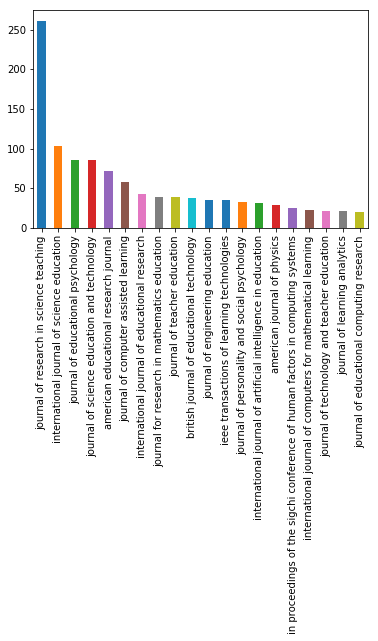

In [43]:
sources.value_counts().head(20).plot(kind='bar')

In [44]:
sources.value_counts().tail(10)

th international conference of                                                                     1
in proceedings of the international conference of multimodal interfaces                            1
british journal of surgery                                                                         1
european journal of teacher education                                                              1
presented at the national council for teachers of mathematics research conference                  1
universal design in education conference                                                           1
social dynamics in conferences analyses of data from the live social semantics application         1
journal of education for business                                                                  1
in the proceedings of the international acm sigaccess conference of computers and accessibility    1
the journal of the learning science                                                        

We analyze how heavy the tail is to find whether we should work on parsing the tail or not:

In [45]:
conference_counts = sources.value_counts()

In [46]:
conference_counts[conference_counts >= 20].sum()

1117

In [47]:
conference_counts[conference_counts < 20].sum()

2053

Conclusion: As the tail accounts for a lage number of conferences better parsing might cause a shift in the most popular conferences. Hence we look into getting more uniform names

A first idea is to look at acronyms..: https://en.wikipedia.org/wiki/List_of_computer_science_conference_acronyms

In [48]:
import urllib3
from bs4 import BeautifulSoup

In [49]:
url = 'https://en.wikipedia.org/wiki/List_of_computer_science_conference_acronyms'
http_pool = urllib3.connection_from_url(url)
r = http_pool.urlopen('GET',url)
data = r.data
soup = BeautifulSoup(data, 'html.parser')
conferences_noisy = soup.find_all('div', class_='mw-parser-output')[0].find_all('li')
abrev_df = pd.DataFrame([c.text.split(' – ') for c in conferences_noisy if reg.search('–', c.text)], columns=['abreviation', 'full_name'])

/anaconda3/envs/Biblio/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


The gives us the following list:

In [50]:
abrev_df.head()

,abreviation,full_name
0,AAAI,AAAI Conference on Artificial Intelligence
1,AAMAS,International Conference on Autonomous Agents ...
2,ABZ,International Conference on Abstract State Mac...
3,ACL,Annual Meeting of the Association for Computat...
4,ALGO,ALGO Conference


Constricting regex for easier searching on both columns:

In [51]:
conf_regex = ' | '.join(abrev_df.abreviation.map(lambda x: x.lower()).tolist())
conf_regex

'aaai | aamas | abz | acl | algo | amcis | ants | ares | asiacrypt | asp-dac | ase | aswec | atmos | cade | cav | cc | ccsc | ches | chi | ciaa | cibb | cicling | cidr | cikm | crypto | cusec | cvpr | dac | date | dcfs | disc | dlt | dsn | ecai | ecco | ecis | ecml pkdd | ecoop | ecss | esa | esop | eswc | etaps | eurocrypt | eurographics | ewsn | fase | fast | fcrc | floc | focs | forte | fossacs | fse | ftp | gd | globecom | graphicon | hicss | hipc | hopl | hot interconnects | icalp | icassp | iccad | icc | iccit | iccv | icdcs | icfp | icis | icl | iclp | icml | icpads | icse | icsoc | icsr | icter | icws | ijcai | ijcar | ijcbs | indocrypt | ipdps | ipsn | isaac | isca | iscas | ismar | iswc | ispd | isscc | iswc | kdd | lics | lrec | mm | mobicom | mobihoc | mobilehci | naacl | nips | nime | oopsla | pacis | pimrc | pkc | pkdd | pldi | plop | podc | pods | popl | post | ppopp | psb | recomb | rev | rsa | rta | sac | sac | same | seams | sefm | sensys | sigcomm | sigcse | sigdoc |

In [52]:
sources.map(lambda x: True if reg.search(conf_regex, x) else False).sum()

36

In [53]:
references.ref.map(lambda x: reg.search(conf_regex, x.lower()).group(0) if reg.search(conf_regex, x.lower()) else None).dropna().value_counts()

 sigcse       29
 chi          28
aaai           7
 nips          5
 same          5
 fast          5
 www           2
 siggraph      2
 cicling       2
 zum           2
 acl           2
 post          2
 usenix        1
 sigdoc        1
 vis           1
 kdd           1
 wine          1
 ijcai         1
 hicss         1
 iswc          1
 sigir         1
Name: ref, dtype: int64

In [54]:
conf_regex = ' |'.join(abrev_df.full_name.map(lambda x: x.lower()).tolist())

In [55]:
references.ref.map(lambda x: reg.search(conf_regex, x.lower()).group(0) if reg.search(conf_regex, x.lower()) else None).dropna().value_counts()

acm technical symposium on computer science education         19
acm conference on human factors in computing systems           8
international symposium on wearable computers                  2
conference on information and knowledge management             2
international joint conference on artificial intelligence      2
world wide web conference                                      1
international symposium on wikis and open collaboration        1
aaai conference on artificial intelligence                     1
international conference on distributed computing systems      1
annual international acm sigir conference                      1
international conference on software engineering               1
acm international conference on design of communication        1
Name: ref, dtype: int64

We see that this doesn't add tooo much information, but it also indicates that people don't really seem to cute much form computer science conferences

### Other conferences

And other idea is to look at non enlish words that come up often, they might be conference names!

In [56]:
import enchant
#check if a word is english
d = enchant.Dict("en_US")

In [57]:
#some issues but works well
d.check("online")

False

In [58]:
potential_abv = [word[0].upper()+word[1:] for sentence in sources.map(lambda x: word_tokenize(x)).tolist() for word in sentence if not d.check(word)]

In [59]:
pd.Series([p for p in potential_abv if not d.check(p) and len(p) > 2 and len(p) < 6]).value_counts().head(20)

Acm      138
Ieee      85
Idc       18
Pre       16
Lak       14
Asee      10
Icer       8
Cscw       8
Aaai       4
Bcs        3
Icmi       3
Igpme      3
Edm        3
Intl       3
Aied       3
Earli      3
Achi       2
Ceur       2
Icsc       2
Jedm       2
dtype: int64

### Looking at the question of creating more uniform names:

We use a similarity measure:

This works somewhat okay, but probably not worth the effort given that this doesn't make sigchi and  ... computer human interaction the same conference

In [60]:
import difflib
difflib.SequenceMatcher(None, 'hello', 'helo').ratio()

0.8888888888888888

In [61]:
d = {}

In [62]:
for i, row in enumerate(sources.unique()):
    for j, row_2 in enumerate(sources.unique()):
        if i > j and row != row_2:
            difference = difflib.SequenceMatcher(None, row, row_2).ratio()
            if difference > 0.9:
                if not row_2 in d.keys():
                    d[row_2] = row

In [63]:
len(d)

223

As everything is fairly regular, maybe rake can give us some titles? -> pretty much the same as we get anyway -> irregular titles are really just infequent

In [64]:
import rake
import operator

In [65]:
rake_object = rake.Rake("SmartStoplist.txt", 26, 10, 10)
keywords = rake_object.run(' . '.join(sources.tolist()))
keywords

[('sigchi conference of human factors in computing systems',
  54.123946851301206),
 ('acm conference of computer supported cooperative work', 44.935864777225866),
 ('acm technical symposium of computer science education', 42.35980681739533),
 ('journal of pre college engineering education research', 40.135182356284375),
 ('journal of research of technology in education', 39.16928709678454),
 ('conference of interaction design and children', 35.2335332858237),
 ('conference of learning analytics and knowledge', 34.97767513845663),
 ('journal of adolescent and adult literacy', 34.58936033874355),
 ('journal of artificial intelligence in education', 34.283014985822845),
 ('journal for research in mathematics education', 34.27898498777122),
 ('journal of research in science teaching', 34.15059196554651),
 ('journal of computers for mathematical learning', 33.97494871788647),
 ('journal of technology and design education', 33.9413210146235),
 ('journal of science education and technology',

## Again looking at the difference between CSCL and ICLS - outside citations:

In [66]:
references['conference'] = sources

In [67]:
references['cited_in'] = references.file.map(lambda x: int(re.search('[\d]{4}',x).group(0)))

In [68]:
references.head()

,ref,file,ref_parsed,year,identifier,conference,cited_in
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,"Lave, J., & Wenger, E. (1991)",1991.0,"Lave, J., & Wenger, E. (1991). Situated learni...",NaN,2018
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2013.0,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",NaN,2018
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",1997.0,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",NaN,2018
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,"Rogoff, B. (1995)",1995.0,"Rogoff, B. (1995). Observing sociocultural act...",NaN,2018
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2012.0,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",NaN,2018


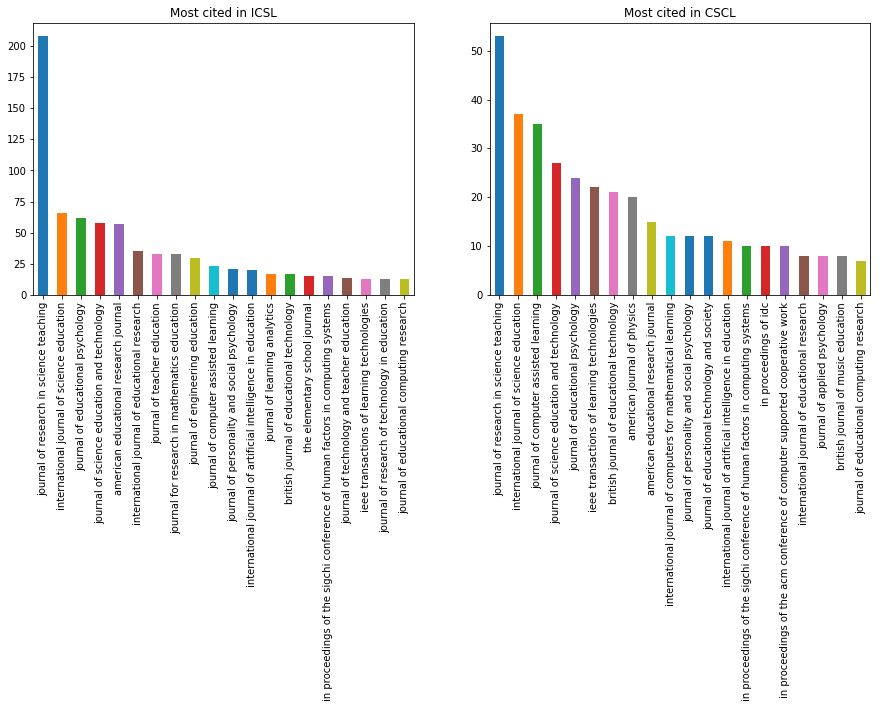

In [69]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Most cited in ICSL')
references[references.cited_in % 2 == 0].conference.value_counts().head(20).plot(kind='bar')

plt.subplot(122)
plt.title('Most cited in CSCL')
references[references.cited_in % 2 == 1].conference.value_counts().head(20).plot(kind='bar')

Top 20 Conferences in both

In [70]:
set(references[references.cited_in % 2 == 0].conference.value_counts().head(20).index).intersection(set(references[references.cited_in % 2 == 1].conference.value_counts().head(20).index))

{'american educational research journal',
 'british journal of educational technology',
 'ieee transactions of learning technologies',
 'in proceedings of the sigchi conference of human factors in computing systems',
 'international journal of artificial intelligence in education',
 'international journal of educational research',
 'international journal of science education',
 'journal of computer assisted learning',
 'journal of educational computing research',
 'journal of educational psychology',
 'journal of personality and social psychology',
 'journal of research in science teaching',
 'journal of science education and technology'}

Conferences in top twenty of ICLS and not CSCL

In [71]:
set(references[references.cited_in % 2 == 0].conference.value_counts().head(20).index) - set(references[references.cited_in % 2 == 1].conference.value_counts().head(20).index)

{'journal for research in mathematics education',
 'journal of engineering education',
 'journal of learning analytics',
 'journal of research of technology in education',
 'journal of teacher education',
 'journal of technology and teacher education',
 'the elementary school journal'}

In [72]:
set(references[references.cited_in % 2 == 0].conference.value_counts().head(50).index) - set(references[references.cited_in % 2 == 1].conference.value_counts().head(50).index)

{'acm transactions of computing education',
 'australasian journal of educational technology',
 'british educational research journal',
 'european journal of social psychology',
 'in proceedings of the annual acm conference of human factors in computing systems',
 'in proceedings of the chi conference of human factors in computing systems',
 'in proceedings of the sixth international conference of learning analytics and knowledge',
 'international journal of designs for learning',
 'international journal of human computer studies',
 'international journal of technology and design education',
 'journal of adolescent and adult literacy',
 'journal of chemical education',
 'journal of curriculum studies',
 'journal of educational change',
 'journal of experimental child psychology',
 'journal of learning analytics',
 'journal of mathematical behavior',
 'journal of pre college engineering education research',
 'journal of science teacher education',
 'journal of writing research',
 'the j

Conferences in top twenty of CSCL and not ICLS

In [73]:
set(references[references.cited_in % 2 == 1].conference.value_counts().head(20).index) - set(references[references.cited_in % 2 == 0].conference.value_counts().head(20).index)

{'american journal of physics',
 'british journal of music education',
 'in proceedings of idc',
 'in proceedings of the acm conference of computer supported cooperative work',
 'international journal of computers for mathematical learning',
 'journal of applied psychology',
 'journal of educational technology and society'}

In [74]:
set(references[references.cited_in % 2 == 1].conference.value_counts().head(50).index) - set(references[references.cited_in % 2 == 0].conference.value_counts().head(50).index)

{'american journal of sociology',
 'british journal of music education',
 'canadian journal of learning and technology',
 'ieee transactions of education',
 'ieee transactions on',
 'in international conference of intelligent tutoring systems',
 'in proceedings of idc',
 'in proceedings of the acm conference of computer supported cooperative work',
 'in proceedings of the conference of human factors in computing systems',
 'in proceedings of the third international conference of learning analytics and knowledge',
 'in world conference of educational multimedia',
 'international journal of artificial intelligence and education',
 'international journal of technology enhanced learning',
 'journal of applied psychology',
 'journal of artificial societies and social simulation',
 'journal of asynchronous learning networks',
 'journal of computer mediated communication',
 'journal of computing sciences in colleges',
 'journal of education and work',
 'journal of educational data mining',
 '